In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from docx import Document
import textblob

### Creating Technical Dataset

In [124]:
spy = pd.read_csv("SPY.csv")

In [125]:
sp = spy[:309]

In [126]:
sp = sp[["Date","Close","Volume"]]

### Creating additional technical variables

In [127]:
# Creating Momentum variable as Mmtm
sp["Mmtm"] = (sp["Close"]-sp["Close"].shift()) * sp["Volume"]

In [128]:
sp["Log_change"] = np.log(sp.Close) - np.log(sp.Close.shift(1))
sp["3sma"] = pd.rolling_mean(sp["Close"],3)
sp["7sma"] = pd.rolling_mean(sp["Close"],7)
sp["12sma"] = pd.rolling_mean(sp["Close"],12)

/Users/kanduri/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  
/Users/kanduri/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kanduri/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.


In [129]:
# Creating SP500/90 day MVA variable
sp["SP500/90MVA"] = sp["Close"]/sp["3sma"]

In [130]:
sp1 = sp.drop("Volume",1)

In [131]:
sp1 = sp1.fillna(0)

In [132]:
sp1.head()

,Date,Close,Mmtm,Log_change,3sma,7sma,12sma,SP500/90MVA
0,1990-01-01,329.079987,0.000000e+00,0.000000,0.000000,0.0,0.0,0.000000
1,1990-02-01,331.890015,8.323219e+09,0.008503,0.000000,0.0,0.0,0.000000
2,1990-03-01,339.940002,2.643036e+10,0.023966,333.636668,0.0,0.0,1.018893
3,1990-04-01,330.799988,-2.560319e+10,-0.027255,334.210002,0.0,0.0,0.989797
4,1990-05-01,361.230011,1.094471e+11,0.088001,343.990000,0.0,0.0,1.050118


### Preparing fundamental Dataset

In [133]:
fund = pd.read_csv("f1.csv")
tentsy = pd.read_csv("10 tsy.csv")
fivetsy = pd.read_csv("5 tsy.csv")
twotsy = pd.read_csv("2 tsy.csv")

In [134]:
#dvrate = Annualized dividend rate
#EPS = Earnings per Share
#Prcrcm =  Closing Price
#10 Tsy = 10 year treasury rate
#5 Tsy = 5 year treasury rate
#2 Tsy = 2 year treasury rate

In [135]:
fund = fund[["dvrate","epsx12","prccm","datadate"]]
fund["PE"] = fund["prccm"]/fund["epsx12"]
fund = fund[["dvrate","datadate","PE"]]
fund["Date"] = fund['datadate'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
fund = fund[["dvrate","PE"]]

In [136]:
TT = tentsy.reindex(index=tentsy.index[::-1])
FT = fivetsy.reindex(index=fivetsy.index[::-1])
TwT = twotsy.reindex(index=twotsy.index[::-1])

In [137]:
fnd = fund.copy()
fnd["10 tsy"] = TT["Price"]
fnd["5 tsy"] = FT["Price"]
fnd["2 tsy"] = TwT["Price"]

### Creating Sentimental Dataset

In [138]:
year = range(1990,2016)

In [139]:
yr = dict.fromkeys(year)

In [140]:
for key in yr.keys():
    f = Document(str(key)+".docx")
    yr[key] = []
    p = []
    s = []
    for para in f.paragraphs:
        an= textblob.TextBlob(para.text)
        sn = an.sentiment
        p.append(sn.polarity)
        s.append(sn.subjectivity)
    yr[key]= [sum(p)/len(p), sum(s)/len(s)]

In [141]:
sent = pd.DataFrame(yr.values())
sent.columns = ["Pol", "Sub"]

In [142]:
pol = sent["Pol"]
pol1 = np.repeat(pol,12)
sub = sent["Sub"]
sub1 = np.repeat(sub,12)
snt = pd.DataFrame()
snt["Pol"] = pol1
snt["Sub"] = sub1
snt =  snt[:309]

In [143]:
snt = snt.reset_index()
snt = snt[["Pol","Sub"]]

### Creating Final Dataset

In [144]:
df = sp1.copy()
f2 = fnd.copy()
s2 = snt.copy()

In [145]:
df = df.join(f2)
df = df.join(s2) #DF is the final dataset

In [146]:
df["Pred"] = np.where(df["Close"]>df["Close"].shift(),1,0)

In [147]:
df.head()

,Date,Close,Mmtm,Log_change,3sma,7sma,12sma,SP500/90MVA,dvrate,PE,10 tsy,5 tsy,2 tsy,Pol,Sub,Pred
0,1990-01-01,329.079987,0.000000e+00,0.000000,0.000000,0.0,0.0,0.000000,11.40,14.389777,2.269,1.766,1.064,0.03096,0.281961,0
1,1990-02-01,331.890015,8.323219e+09,0.008503,0.000000,0.0,0.0,0.000000,11.40,14.512655,2.208,1.654,0.934,0.03096,0.281961,1
2,1990-03-01,339.940002,2.643036e+10,0.023966,333.636668,0.0,0.0,1.018893,11.04,15.687120,2.146,1.528,0.736,0.03096,0.281961,1
3,1990-04-01,330.799988,-2.560319e+10,-0.027255,334.210002,0.0,0.0,0.989797,11.04,15.265335,2.035,1.375,0.645,0.03096,0.281961,0
4,1990-05-01,361.230011,1.094471e+11,0.088001,343.990000,0.0,0.0,1.050118,11.04,16.669589,2.214,1.541,0.739,0.03096,0.281961,1


### Data Manipulation

In [148]:
# Our goal is to predict the movement of the S&P 500 using the previous months data
# For example, We have to predict the Febraury movement using the January Data
# So Our target variable is 1 step ahead of the X-Variables
# To Compensate we shift our target variable one step back wards

In [149]:
df["Pred"] = df["Pred"].shift(-1)
df = df.fillna(0)

### Creating Final Feature and Prediction variable Datasets

In [150]:
#Dataset of Dates
df_date = df["Date"]

In [151]:
# Dataset Of X-Variables
df_x = df[["Mmtm","Log_change","3sma","7sma","12sma","SP500/90MVA","dvrate","PE","10 tsy","5 tsy","2 tsy","Pol","Sub"]]

In [152]:
#Dataset Of Y-variables
df_y = df["Pred"]

### Normalizing Data

In [153]:
#This data is Panel data.So, the terms like Close and Volume will consistetly increase with time.
#So it doesn't make any sense to Normalize the data
#So instead we take the Log differntiation for some Momentum variable to solve this.
# We are doing this only for momentum variable because they differ from other variables by a very large margin

In [154]:
df_x["Mmtm"] = np.log(df_x.Mmtm) - np.log(df_x.Mmtm.shift(1))

/Users/kanduri/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/kanduri/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/Users/kanduri/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [155]:
df_x = df_x.replace(np.inf, np.nan)
df_x=df_x.fillna(0)

In [156]:
# Our final set of X-Variables
df_x.head()

,Mmtm,Log_change,3sma,7sma,12sma,SP500/90MVA,dvrate,PE,10 tsy,5 tsy,2 tsy,Pol,Sub
0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,11.40,14.389777,2.269,1.766,1.064,0.03096,0.281961
1,0.000000,0.008503,0.000000,0.0,0.0,0.000000,11.40,14.512655,2.208,1.654,0.934,0.03096,0.281961
2,1.155464,0.023966,333.636668,0.0,0.0,1.018893,11.04,15.687120,2.146,1.528,0.736,0.03096,0.281961
3,0.000000,-0.027255,334.210002,0.0,0.0,0.989797,11.04,15.265335,2.035,1.375,0.645,0.03096,0.281961
4,0.000000,0.088001,343.990000,0.0,0.0,1.050118,11.04,16.669589,2.214,1.541,0.739,0.03096,0.281961


### Building our Models

In [157]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, shuffle=False)

In [158]:
def roc_curve(y_test,y_predicted_probability,pos_label=None):
    if pos_label==None:
        pos_label=1
    fpr,tpr,thresholds=metrics.roc_curve(y_test,y_predicted_probability,pos_label=pos_label )
    plt.plot(fpr,tpr)
    plt.xlabel("False Positive rate")
    plt.ylabel("True Positive rate")
    plt.title("ROC Curve")
    plt.xlim(0.0,1.0)
    plt.ylim(0.0,1.0)
    plt.grid(True)
    print "AUC of the model is {:.10f}".format(metrics.roc_auc_score(y_test,y_predicted_probability))
    plt.show()

#### Logistic Regression Model

In [159]:
lgtr = LogisticRegression(penalty = "l1", random_state = 42)

In [160]:
lgtr = lgtr.fit(X_train,y_train)

In [161]:
y_predlrm = lgtr.predict(X_test)

In [162]:
print "Accuracy: ",accuracy_score(y_test, y_predlrm)
print "Precision: ",precision_score(y_test, y_predlrm)
print "Recall: ",recall_score(y_test, y_predlrm)

Accuracy:  0.52688172043
Precision:  0.571428571429
Recall:  0.857142857143


AUC of the model is 0.4420849421


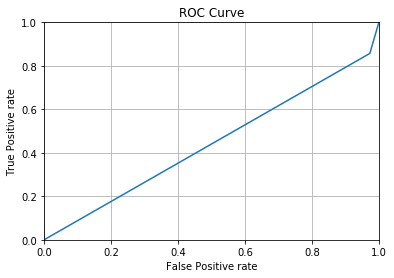

In [163]:
roc_curve(y_test, y_predlrm, pos_label=None)

#### SVM Model

In [164]:
# Creating a Model using Polynomial kernel
psvm = SVC(random_state = 42)

In [165]:
psvm.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [166]:
y_predpsvm = psvm.predict(X_test)

In [167]:
print "Accuracy: ",accuracy_score(y_test, y_predpsvm)
print "Precision: ",precision_score(y_test, y_predpsvm)
print "Recall: ",recall_score(y_test, y_predpsvm)

Accuracy:  0.602150537634
Precision:  0.602150537634
Recall:  1.0


AUC of the model is 0.5000000000


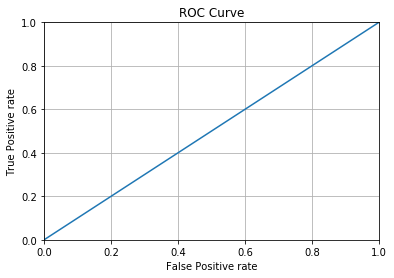

In [168]:
roc_curve(y_test,y_predpsvm,pos_label=None)

#### Random Forest Model

In [169]:
rfr = RandomForestClassifier(n_estimators = 100, oob_score =  True, random_state = 42)

In [170]:
rfr = rfr.fit(X_train,y_train)

In [171]:
y_predrfr = rfr.predict(X_test)

In [172]:
print "Accuracy: ",accuracy_score(y_test, y_predrfr)
print "Precision: ",precision_score(y_test, y_predrfr)
print "Recall: ",recall_score(y_test, y_predrfr)

Accuracy:  0.462365591398
Precision:  0.557692307692
Recall:  0.517857142857


AUC of the model is 0.4481177606


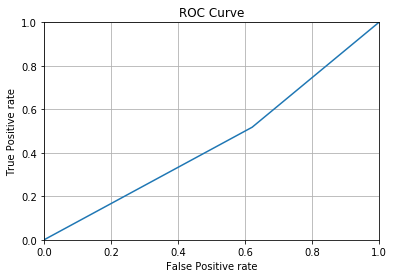

In [173]:
roc_curve(y_test,y_predrfr,pos_label=None)

#### Neural Network Model

In [174]:
nnm = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(66,33,10,1), max_iter =1000000,batch_size=2000, random_state = 42)

In [175]:
nnm = nnm.fit(X_train.as_matrix().astype(np.float), y_train.values.ravel())

In [176]:
y_prednnm = nnm.predict(X_test)

In [177]:
print "Accuracy: ",accuracy_score(y_test, y_prednnm)
print "Precision: ",precision_score(y_test, y_prednnm)
print "Recall: ",recall_score(y_test, y_prednnm)

Accuracy:  0.602150537634
Precision:  0.602150537634
Recall:  1.0


AUC of the model is 0.5000000000


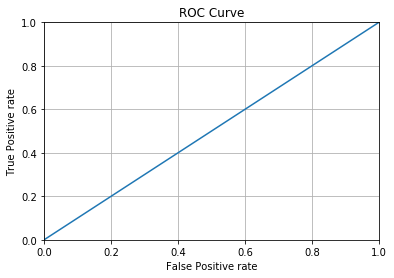

In [178]:
roc_curve(y_test,y_prednnm,pos_label=None)

### Building Models with Cross Validation

In [183]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier(n_estimators = 100, oob_score =  True, random_state = 42)))
models.append(('SVM', SVC()))
models.append(('MLP', MLPClassifier(solver='lbfgs',hidden_layer_sizes=(66,33,10,1), max_iter =1000000,batch_size=2000)))
#Evaluate each model
#K-fold for more accuracy (but slow; all the data is used for testing and training)
results = []
names = []

In [185]:
for name, model in models:
    kfold = KFold(n_splits = 5, random_state = 42)
    cv_results = cross_val_score(model, df_x, df_y, cv = kfold, scoring = "accuracy")
    cv_results1 = cross_val_score(model, df_x, df_y, cv = kfold, scoring = "precision")
    cv_results2 = cross_val_score(model, df_x, df_y, cv = kfold, scoring = "recall")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f %f %f" % (name, cv_results.mean(), cv_results1.mean(), cv_results2.mean())
    print(msg)

LR: 0.572448 0.636009 0.775146
RF: 0.569276 0.624613 0.769602
SVM: 0.624590 0.624590 1.000000
MLP: 0.621364 0.624590 1.000000


### Evaluating performance of each model with $1,00,000 investment

In [186]:
# roe is a function which shows the value of investment over 25 years
def roe(model):
    spy = sp[:310]
    spy1 = spy[["Date","Close"]]
    spy1["PctChange"] = spy1["Close"].pct_change()
    spy1 = spy1.fillna(0)
    pc = spy1["PctChange"]
    spy = spy1["PctChange"]
    pred = model.predict(df_x)
    spy1["pred"] = pred
    pred1 = np.where(pred>0.0,1,-1)
    spy1["pred1"] = pred1
    pct1 = pred1 * pc
    spy1["pct1"] = pct1
    pct2 = pct1 + 1.0
    spy1["pct2"] = pct2
    pctc = np.cumprod(pct2)
    spy1["pctc"] = pctc
    inv = 100000.0 * pctc 
    spy1["Inv"] = inv
    return spy1["Inv"]

In [187]:
Ilgtr = roe(lgtr)
Irfr = roe(rfr)
Ipsvm = roe(psvm)
Innm = roe(nnm)

/Users/kanduri/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


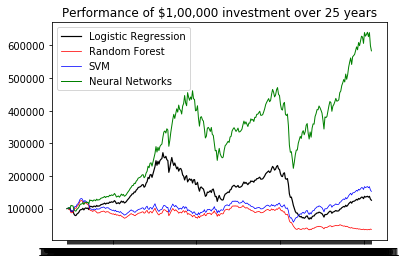

In [188]:
plt.plot(df_date, Ilgtr,label = "Logistic Regression", color = "k", ls = "-", lw = 1.2)
plt.plot(df_date, Irfr,label = "Random Forest", color = "r", ls = "-", lw = 0.75) 
plt.plot(df_date, Ipsvm,label = "SVM", color = "b", ls = "-", lw = 0.75) 
plt.plot(df_date, Innm,label = "Neural Networks", color = "g", ls = "-", lw = 1.0) 
plt.title("Performance of $1,00,000 investment over 25 years")
plt.legend()
plt.show()